In [1]:
# !pip install brian2
# !pip install matplotlib
# import packages
import numpy as np
from brian2 import *
import matplotlib.pyplot as plt
import os
import pickle
import seaborn as sns

import scienceplots
plt.style.use('science')
plt.style.use(['no-latex'])

import structure

In [2]:
import random
tseed = random.randint(0, 10000)
random.seed(5*tseed)
np.random.seed(tseed)
print(f"seed: {tseed}")

seed: 9304


In [3]:
# NE = 800         # Number of excitatory cells
NE = 900
NP = 100         # number of PV cells (symmetric iSTDP)
NS = 100         # number of SST cells (antisymmetric iSTDP)

# simulation time
time_warmup = 3.0 # Warmup time (seconds)
time_training = 1500.0 # Simulation time (seconds)
time_checkspikes = 60.0 # record spikes of exc population here

# ###########################################
# Neuron model
# ###########################################
tau_ampa = 5.0 # Glutamatergic synaptic time constant (ms)
tau_gaba = 10.0 # GABAergic synaptic time constant (ms)
gl = 10.0
el = -60.0
er = -80.0
vt = -50.0
memc = 200.0  # Membrane capacitance
# background currents
bg_current_e = 1000.0 # External current (pA)
bg_current_p = 0.0
bg_current_s = 0.0
# noisy input for exc
n_input_e = 200
rate_input_e = 80 # (Hz)
strength_input_e = 1.0 # (mV)
# noisy input for PV
n_input_p = 200
rate_input_p = 40 # (Hz)
strength_input_p = 1.0 # (mV)
# noisy input for SST
n_input_s = 200
rate_input_s = 40 # (Hz)
strength_input_s = 1.0 # (mV)
    
# connection sparseness (inh. only)
connprob_sp = 0.9
connprob_ss = 0.9
connprob_ps = 0.9
connprob_pp = 0.9
# ring parameters (lower is broader)
k_ring_ee=10.0 
k_ring_ep=5.0 
k_ring_es=10.0 
# connection weights
w_ee_sum = 145.0 # exc to exc, SUM
w_ep_sum,w_es_sum = 145.0,145.0 # exc to inh SUM
w_ps,w_sp = 1.0,1.0
w_ss,w_pp = 2.5,2.5
w_pe,w_se= 3.0,3.0 # the plastic ones
w_ee=3.0
# Maximum inhibitory weight
weigh_max = 80

A0learn_e = 1E-3 

# STDP parameters for PV to exc
A0learn_p = 2E-3
theta_p = -1.0
gamma_p = 20.0
alpha_pre_p = -0.2
alpha_post_p = 1.0
tauplus_stdp_p = 30.0    # STDP time constant (ms)

# STDP parameters for SST to exc
A0learn_s = 1E-3
theta_s = -1.0
gamma_s = 1.0
alpha_pre_s = -0.2
alpha_post_s = 1.0
tauplus_stdp_s = 30.0    # STDP time constant (ms)

# Simulation details
save_id = 'torus_structure_two_interneurons'

In [4]:
Lx, Ly = 1.0, 1.0 

pos_e = structure.assign_positions_2d(NE, Lx, Ly)
pos_p = structure.assign_positions_2d(NP, Lx, Ly)
pos_s = structure.assign_positions_2d(NS, Lx, Ly)

sx_ee = sy_ee = 0.10   # E->E
sx_ep = sy_ep = 0.20   # E->PV
sx_es = sy_es = 0.20   # E->SST

print(f"sx_ee: {sx_ee:2f}, sy_ee: {sy_ee:2f}")
print(f"sx_ep: {sx_ep:2f}, sy_ep: {sy_ep:2f}")
print(f"sx_es: {sx_es:2f}, sy_es: {sy_es:2f}")

rmax_ee = None
rmax_ep = None
rmax_es = None

w_thresh_torus = 1e-6

sx_ee: 0.100000, sy_ee: 0.100000
sx_ep: 0.200000, sy_ep: 0.200000
sx_es: 0.200000, sy_es: 0.200000


In [5]:

print(f'NE is {NE}, NP is {NP}, NS is {NS}')

eqs_neurons_e='''
    input_contrast : 1
    dv/dt=(-(gl*nsiemens)*(v-el*mV)-(g_ampa*v+g_gaba*(v-er*mV))+bg_current_e*pA)/(memc*pfarad) : volt (unless refractory)
    dg_ampa/dt = -g_ampa/(tau_ampa*ms) : siemens
    dg_gaba/dt = -g_gaba/(tau_gaba*ms) : siemens
'''

eqs_neurons_p='''
    dv/dt=(-(gl*nsiemens)*(v-(el*mV))-(g_ampa*v+g_gaba*(v-(er*mV)))+bg_current_p*pA)/(memc*pfarad) : volt (unless refractory)
    dg_ampa/dt = -g_ampa/(tau_ampa*ms) : siemens
    dg_gaba/dt = -g_gaba/(tau_gaba*ms) : siemens
'''

eqs_neurons_s='''
    dv/dt=(-(gl*nsiemens)*(v-(el*mV))-(g_ampa*v+g_gaba*(v-(er*mV)))+bg_current_s*pA)/(memc*pfarad) : volt (unless refractory)
    dg_ampa/dt = -g_ampa/(tau_ampa*ms) : siemens
    dg_gaba/dt = -g_gaba/(tau_gaba*ms) : siemens
'''

# ###########################################
# Initialize neuron group
# ###########################################
Pe = NeuronGroup(NE, model=eqs_neurons_e, threshold='v > (vt*mV)',
                 reset='v=(el*mV)', refractory=5*ms, method='euler')
Pp = NeuronGroup(NP, model=eqs_neurons_p, threshold='v > (vt*mV)',
                 reset='v=(el*mV)', refractory=5*ms, method='euler')
Ps = NeuronGroup(NS, model=eqs_neurons_s, threshold='v > (vt*mV)',
                 reset='v=(el*mV)', refractory=5*ms, method='euler')

PIe = PoissonInput(Pe, 'g_ampa', n_input_e, rate_input_e*Hz, weight=strength_input_e*nS)
PIp = PoissonInput(Pp, 'g_ampa', n_input_p, rate_input_p*Hz, weight=strength_input_p*nS)
PIs = PoissonInput(Ps, 'g_ampa', n_input_s, rate_input_s*Hz, weight=strength_input_s*nS)

# ##########################################
# Connecting the network
# ###########################################

# exc to exc and to inh
con_ee = Synapses(Pe, Pe,model='w:1', on_pre='g_ampa += w*nS') 
con_ep = Synapses(Pe, Pp,model='w:1', on_pre='g_ampa += w*nS')
con_es = Synapses(Pe, Ps,model='w:1', on_pre='g_ampa += w*nS')
# inh to inh 
con_ps = Synapses(Pp, Ps, on_pre='g_gaba += w_ps*nS')
con_sp = Synapses(Ps, Pp, on_pre='g_gaba += w_sp*nS')
con_pp = Synapses(Pp, Pp, on_pre='g_gaba += w_pp*nS')
con_ss = Synapses(Ps, Ps, on_pre='g_gaba += w_ss*nS')


# ###########################################
# Inhibitory to inhibitory connections
# ###########################################
con_sp.connect(p=connprob_sp)
con_ps.connect(p=connprob_ps)
con_pp.connect(p=connprob_pp)
con_ss.connect(p=connprob_ss)


# ###################################################
# Excitatory connections implement the torus structure
# ##################################################

# # E to E connections
W_ee = structure.make_torus_pre_post_fixed_sum(
    pre_pos=pos_e, post_pos=pos_e, wsum=w_ee_sum,
    sx=sx_ee, sy=sy_ee, Lx=Lx, Ly=Ly,
    r_max=rmax_ee, w_thresh=w_thresh_torus, avoid_self_connections=True
)
idxee_pre, idxee_post, wvals_ee = structure.wmat_to_lists(W_ee)
con_ee.connect(i=idxee_pre, j=idxee_post)
con_ee.w = wvals_ee

# E -> PV
W_ep = structure.make_torus_pre_post_fixed_sum(
    pre_pos=pos_e, post_pos=pos_p, wsum=w_ep_sum,
    sx=sx_ep, sy=sy_ep, Lx=Lx, Ly=Ly,
    r_max=rmax_ep, w_thresh=w_thresh_torus, avoid_self_connections=True
)
idxep_pre, idxep_post, wvals_ep = structure.wmat_to_lists(W_ep)
con_ep.connect(i=idxep_pre, j=idxep_post)
con_ep.w = wvals_ep

# E -> SST
W_es = structure.make_torus_pre_post_fixed_sum(
    pre_pos=pos_e, post_pos=pos_s, wsum=w_es_sum,
    sx=sx_es, sy=sy_es, Lx=Lx, Ly=Ly,
    r_max=rmax_es, w_thresh=w_thresh_torus, avoid_self_connections=True
)
idxes_pre, idxes_post, wvals_es = structure.wmat_to_lists(W_es)
con_es.connect(i=idxes_pre, j=idxes_post)
con_es.w = wvals_es

# ###########################################
# Inhibitory Plasticity
# ###########################################
A0_p = 0.0 # start with no learning
A0_s = 0.0 # start with no learning

# derived parameters
tauminus_stdp_p = gamma_p*tauplus_stdp_p
tauminus_stdp_s = gamma_s*tauplus_stdp_s

# NOT scaled by A0 here (since it controls learning on/off)
Aplus_p = float(1/tauplus_stdp_p)*1E3 # time was in ms, needs to be seconds
Aminus_p = float(theta_p/tauminus_stdp_p)*1E3
print(f"Aplus_p: {Aplus_p:2f}; Aminus_p: {Aminus_p:2f}")

Aplus_s = float(1/tauplus_stdp_s)*1E3
Aminus_s = float(theta_s/tauminus_stdp_s) *1E3
print(f"Aplus_s: {Aplus_s:2f}; Aminus_s: {Aminus_s:2f}")

# modify to let the SST kernel not perfectly antisymmetric
modify_amplitude = True 
if modify_amplitude:
    amp_scale = 1.0
    Aplus_s_new = amp_scale * Aplus_s
    tauplus_stdp_s_new_ms = (-Aminus_s * tauminus_stdp_s) / Aplus_s_new 
    # overwrite the original values
    Aplus_s = float(Aplus_s_new)
    tauplus_stdp_s = float(tauplus_stdp_s_new_ms)

    area_pos = Aplus_s * tauplus_stdp_s         
    area_neg = Aminus_s * tauminus_stdp_s 
    print(f"area_pos: {area_pos:2f}; area_neg: {area_neg:2f}")

# simple traces for pre- and postsynaptic activity
# (that need to be rescaled)

eqs_stdp_inhib_p = '''
    w : 1
    dtrace_pre_plus/dt=-trace_pre_plus/(tauplus_stdp_p*ms) : 1 (event-driven)
    dtrace_pre_minus/dt=-trace_pre_minus/(tauminus_stdp_p*ms) : 1 (event-driven)
    dtrace_post_plus/dt=-trace_post_plus/(tauplus_stdp_p*ms) : 1 (event-driven)
    dtrace_post_minus/dt=-trace_post_minus/(tauminus_stdp_p*ms) : 1 (event-driven)
'''

con_pe = Synapses(Pp, Pe, model=eqs_stdp_inhib_p,
    on_pre='''
        trace_pre_plus += 1.0
        trace_pre_minus += 1.0
        w = clip(w + A0_p*(alpha_pre_p + Aplus_p*trace_post_plus + Aminus_p*trace_post_minus), 0, weigh_max)
        g_gaba += w*nS
    ''',
    on_post='''
        trace_post_plus += 1.0
        trace_post_minus += 1.0
        w = clip(w + A0_p*(alpha_post_p + Aplus_p*trace_pre_plus + Aminus_p*trace_pre_minus), 0, weigh_max)
    ''')
con_pe.connect()
con_pe.w = w_pe

    
eqs_stdp_inhib_s = '''
    w : 1
    dtrace_plus/dt=-trace_plus/(tauplus_stdp_s*ms) : 1 (event-driven)
    dtrace_minus/dt=-trace_minus/(tauminus_stdp_s*ms) : 1 (event-driven)
'''

con_se = Synapses(Ps, Pe, model=eqs_stdp_inhib_s,
    on_pre='''
        trace_plus += 1.0
        w = clip(w + A0_s*(alpha_pre_s + Aminus_s*trace_minus), 0, weigh_max)
        g_gaba += w*nS''',
    on_post='''
        trace_minus += 1.0
        w = clip(w + A0_s*(alpha_post_s + Aplus_s*trace_plus), 0, weigh_max)''')
con_se.connect()
con_se.w = w_se

# ###########################################
# Setting up monitors
# ###########################################

# population rates
pop_re_mon = PopulationRateMonitor(Pe)
pop_rp_mon = PopulationRateMonitor(Pp)
pop_rs_mon = PopulationRateMonitor(Ps)
    
# exc spikes
spk_e_mon = SpikeMonitor(Pe)
# pv spikes
spk_p_mon = SpikeMonitor(Pp)
# sst spikes
spk_s_mon = SpikeMonitor(Ps)
    
spk_e_mon.active=False
spk_p_mon.active=False
spk_s_mon.active=False

pop_re_mon.active=False
pop_rp_mon.active=False
pop_rs_mon.active=False

NE is 900, NP is 100, NS is 100


WARNING    Removing unsupported flag '-march=native' from compiler flags. [brian2.codegen.cpp_prefs]


Aplus_p: 33.333333; Aminus_p: -1.666667
Aplus_s: 33.333333; Aminus_s: -33.333333
area_pos: 1000.000000; area_neg: -1000.000000


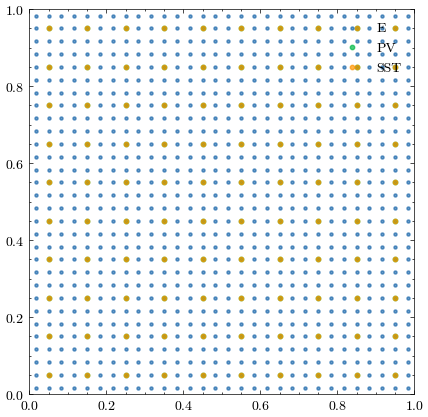

In [6]:
fig, ax = plt.subplots(1,1,figsize=(5,5))
ax.scatter(pos_e[:,0], pos_e[:,1], s=5, label='E', alpha=0.6)
ax.scatter(pos_p[:,0], pos_p[:,1], s=10, label='PV', alpha=0.7)
ax.scatter(pos_s[:,0], pos_s[:,1], s=10, label='SST', alpha=0.7)
ax.set_xlim(0, Lx)
ax.set_ylim(0, Ly)
fig.gca().set_aspect('equal', adjustable='box')
ax.legend()
fig.savefig(f"../Figures/torus_positions_seed{tseed}.png", dpi=300)

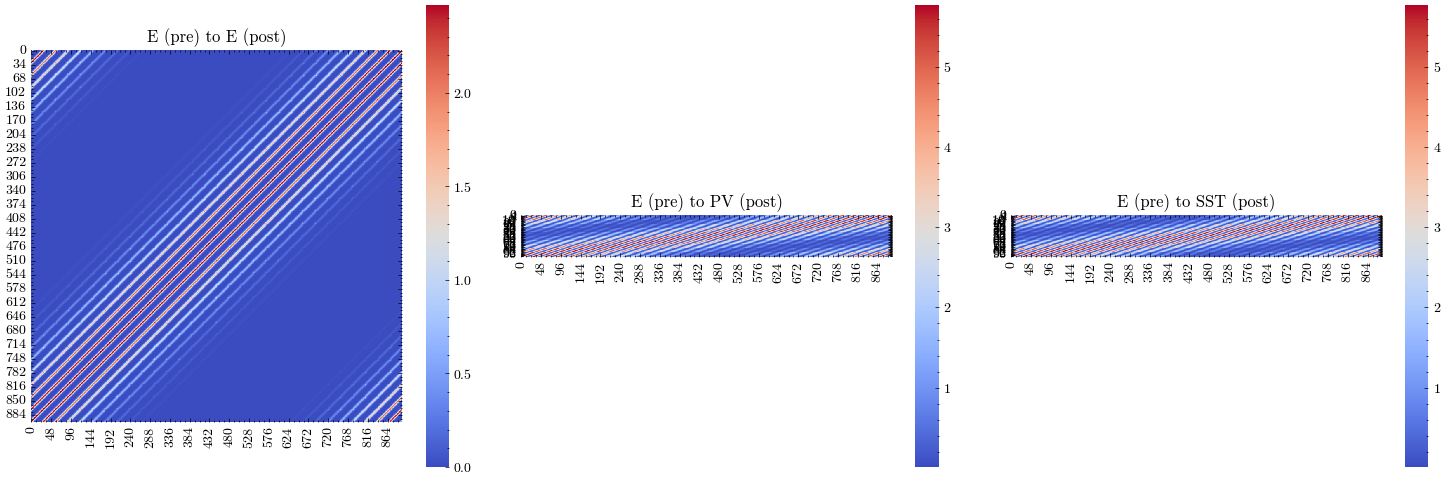

In [7]:
ext_ext_init_weights = np.zeros((NE, NE))
for i in range(len(idxee_pre)):
    ext_ext_init_weights[idxee_pre[i], idxee_post[i]] = wvals_ee[i]
    
ext_pv_init_weights = np.zeros((NE, NP))
for i in range(len(idxep_pre)):
    ext_pv_init_weights[idxep_pre[i], idxep_post[i]] = wvals_ep[i]

ext_sst_init_weights = np.zeros((NE, NS))
for i in range(len(idxes_pre)):
    ext_sst_init_weights[idxes_pre[i], idxes_post[i]] = wvals_es[i]

# similar to the layout (in terms of rotation) with Figure 4
fig, ax = plt.subplots(1,3, figsize=(15,5))
sns.heatmap(np.rot90(ext_ext_init_weights), ax=ax[0], cmap='coolwarm', cbar=True, square=True)
sns.heatmap(np.rot90(ext_pv_init_weights), ax=ax[1], cmap='coolwarm', cbar=True, square=True)
sns.heatmap(np.rot90(ext_sst_init_weights), ax=ax[2], cmap='coolwarm', cbar=True, square=True)
ax[0].set_title('E (pre) to E (post)')
ax[1].set_title('E (pre) to PV (post)')
ax[2].set_title('E (pre) to SST (post)')
fig.tight_layout()
fig.savefig(f"../Figures/torus_initial_weights_seed{tseed}.png", bbox_inches='tight', dpi=300)

tau_plus_p: 30.0; tau_minus_p: 600.0; tau_plus_s: 30.0; tau_minus_s: 30.0
I_pv: 0.000000; I_sst: -0.000667


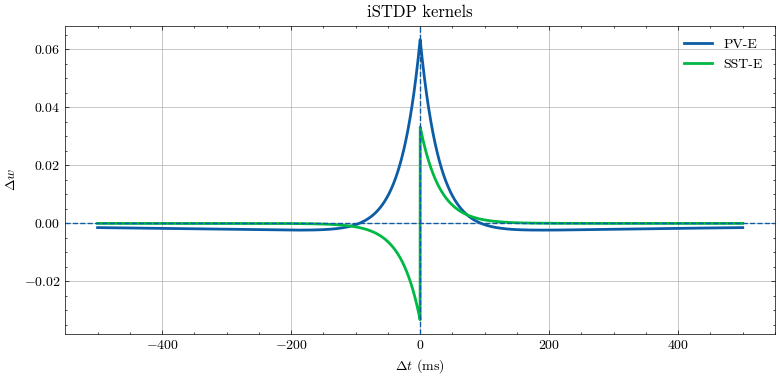

In [8]:
tau_plus_p = tauplus_stdp_p   
tau_minus_p = tauminus_stdp_p
tau_plus_s = tauplus_stdp_s        
tau_minus_s = tauminus_stdp_s

print(f"tau_plus_p: {tau_plus_p}; tau_minus_p: {tau_minus_p}; tau_plus_s: {tau_plus_s}; tau_minus_s: {tau_minus_s}")

def kernel_pv(dt_ms):
    return A0learn_p * (Aplus_p * np.exp(-np.abs(dt_ms) / tau_plus_p)
                        + Aminus_p * np.exp(-np.abs(dt_ms) / tau_minus_p))

def kernel_sst(dt_ms):
    out = np.zeros_like(dt_ms, dtype=float)
    pos = dt_ms > 0
    neg = ~pos
    out[pos] = A0learn_s * (Aplus_s  * np.exp(-dt_ms[pos] / tau_plus_s))
    out[neg] = A0learn_s * (Aminus_s * np.exp(+dt_ms[neg] / tau_minus_s))  
    return out

def remove_near_zero(lst, eps=1e-8):
    """
    """
    return np.array([x for x in lst if abs(x) > eps])

dt_ms_test = np.linspace(-10000, 10000, 1000001)
dt_ms_show = np.linspace(-500, 500, 10001)

kpv_test = kernel_pv(dt_ms_test)
ksst_test = kernel_sst(remove_near_zero(dt_ms_test))

kpv  = kernel_pv(dt_ms_show)
ksst = kernel_sst(remove_near_zero(dt_ms_show))

# half area should be positive and half negative and roughly match in magnitude
I_pv  = np.trapz(kernel_pv(dt_ms_test), dt_ms_test)
I_sst = np.trapz(kernel_sst(dt_ms_test), dt_ms_test)
print(f"I_pv: {I_pv:2f}; I_sst: {I_sst:2f}")

fig, ax = plt.subplots(1,1,figsize=(8,4))
ax.plot(dt_ms_show, kpv,  lw=2, label='PV-E')
ax.plot(remove_near_zero(dt_ms_show), ksst, lw=2, label='SST-E')
ax.axhline(0, ls='--', lw=1)
ax.axvline(0, ls='--',  lw=1)
ax.set_xlabel(r'$\Delta t$ (ms)')
ax.set_ylabel(r'$\Delta w$')
ax.set_title('iSTDP kernels')
ax.legend()
ax.grid(True)
fig.tight_layout()
fig.savefig(f'../Figures/torus_istdp_kernels_seed{tseed}.png', bbox_inches='tight', dpi=300)

In [9]:
# ###########################################
# Run warmup (no plasticity, no recording)
# ###########################################print('Running warmup')
print('Running warmup')
run(time_warmup*second)
print('Warmup done, now running with plasticity')

# ###########################################
# Run with plasticity and monitors, except spiketimes
# ###########################################
A0_p = A0learn_p
A0_s = A0learn_s

pop_re_mon.active=True
pop_rp_mon.active=True
pop_rs_mon.active=True

run(time_training*second, report='text',report_period=60.0*second)

print('weight training complete, now recording spike trains...')

# ###########################################
# Now final run with spiketime recorder
# ###########################################
spk_e_mon.active=True
spk_p_mon.active=True
spk_s_mon.active=True
run(time_checkspikes*second, report='text')

print('******* \nRuns completed, preparing objects to save\n*******')


Running warmup
Warmup done, now running with plasticity
Starting simulation at t=3. s for a duration of 1.5 ks
60.7011 s (4%) simulated in 1m 0s, estimated 23m 43s remaining.
118.9283 s (7%) simulated in 2m 0s, estimated 23m 14s remaining.
176.6703 s (11%) simulated in 3m 0s, estimated 22m 28s remaining.
233.9985 s (15%) simulated in 4m 0s, estimated 21m 38s remaining.
293.8097 s (19%) simulated in 5m 0s, estimated 20m 32s remaining.
0.3555419 ks (23%) simulated in 6m 0s, estimated 19m 19s remaining.
0.4165159 ks (27%) simulated in 7m 0s, estimated 18m 13s remaining.
0.477534 ks (31%) simulated in 8m 0s, estimated 17m 8s remaining.
0.5395328 ks (35%) simulated in 9m 0s, estimated 16m 1s remaining.
0.6019632 ks (40%) simulated in 10m 0s, estimated 14m 55s remaining.
0.6648081 ks (44%) simulated in 11m 0s, estimated 13m 49s remaining.
0.7266297 ks (48%) simulated in 12m 0s, estimated 12m 46s remaining.
0.7901055 ks (52%) simulated in 13m 0s, estimated 11m 41s remaining.
0.8540464 ks (56%

In [10]:

def fill_like(vec,val):
    n= len(vec)
    return np.full(n,val)
    
w_e2e_components = {
    'NE' : NE,
    'con_ee_ijw': np.stack(
            (np.array(con_ee.i),np.array(con_ee.j),np.array(con_ee.w)),axis=-1),
}
w_e2p_components = {
    'NE' : NE,
    'NP':NP,
    'con_ep_ijw': np.stack(
        (np.array(con_ep.i),np.array(con_ep.j),np.array(con_ep.w)),axis=-1),
}
w_p2e_components = {
    'NP':NP,
    'NE':NE,
    'con_pe_ijw': np.stack(
        (np.array(con_pe.i),np.array(con_pe.j),con_pe.w),axis=-1),
    }
w_p2p_components = {
    'NP':NP,
    'con_pp_ijw': np.stack(
            (np.array(con_pp.i),np.array(con_pp.j),fill_like(con_pp.i,w_pp)),axis=-1),
}

w_e2s_components = {
    'NE' : NE,
    'NS':NS,
    'con_es_ijw': np.stack(
        (np.array(con_es.i),np.array(con_es.j),np.array(con_es.w)),axis=-1),
    }
w_s2e_components = {
    'NS':NS,
    'NE':NE,
    'con_se_ijw': np.stack(
        (np.array(con_se.i),np.array(con_se.j),con_se.w),axis=-1),
    }
w_s2s_components = {
    'NS':NS,
    'con_ss_ijw': np.stack(
        (np.array(con_ss.i),np.array(con_ss.j),fill_like(con_ss.i,w_ss)),axis=-1),
    }
w_p2s_components = {
    'NP':NP,
    'NS':NS,
    'con_ps_ijw': np.stack(
        (np.array(con_ps.i),np.array(con_ps.j),fill_like(con_ps.i,w_ps)),axis=-1),
}
w_s2p_components = {
    'NS':NS,
    'NP':NP,
    'con_sp_ijw': np.stack(
        (np.array(con_sp.i),np.array(con_sp.j),fill_like(con_sp.i,w_sp)),axis=-1),
}

# Export population rates
pop_re_times = pop_re_mon.t / second
pop_re_rates = pop_re_mon.smooth_rate(window='gaussian',width=0.05*second) / Hz
pop_rp_times = pop_rp_mon.t / second
pop_rp_rates = pop_rp_mon.smooth_rate(window='gaussian',width=0.05*second) / Hz
pop_rs_times = pop_rs_mon.t / second
pop_rs_rates = pop_rs_mon.smooth_rate(window='gaussian',width=0.05*second) / Hz
    
print('Now saving data on file')

Now saving data on file


In [11]:
save_dict = { 
        'ne':NE,
        'np':NP,
        'ns':NS,
        'w_e2e_components':w_e2e_components,
        'w_e2p_components':w_e2p_components,
        'w_e2s_components':w_e2s_components,
        'w_p2e_components':w_p2e_components,
        'w_s2e_components':w_s2e_components,
        'w_p2s_components':w_p2s_components,
        'w_s2p_components':w_s2p_components,
        'w_p2p_components':w_p2p_components,
        'w_s2s_components':w_s2s_components,
        'pop_re_times':pop_re_times,
        'pop_re_rates':pop_re_rates,
        'pop_rp_times':pop_rp_times,
        'pop_rp_rates':pop_rp_rates,
        'pop_rs_times':pop_rs_times,
        'pop_rs_rates':pop_rs_rates,
        'spikeindices_e':np.array(spk_e_mon.i),
        'spiketimes_e':np.array(spk_e_mon.t/second),
        'spikeindices_p':np.array(spk_p_mon.i),
        'spiketimes_p':np.array(spk_p_mon.t/second),
        'spikeindices_s':np.array(spk_s_mon.i),
        'spiketimes_s':np.array(spk_s_mon.t/second),
        }

savetemppath = f'brian2network_{save_id}_seed{seed}.pkl'
# # if file exists, create new file with random string added
# while os.path.exists(savetemppath):
#     savetemppath =  f'brian2network_{save_id}_{np.random.randint(1000)}.pkl'
# with open(savetemppath,'wb') as f:
#     pickle.dump(save_dict,f)
# print(f'Created temporary file {savetemppath} to store data')

print('******* \n Run completed!\n*******')

******* 
 Run completed!
*******


In [20]:
pop_re_times

array([   3.    ,    3.0001,    3.0002, ..., 1562.9997, 1562.9998,
       1562.9999])

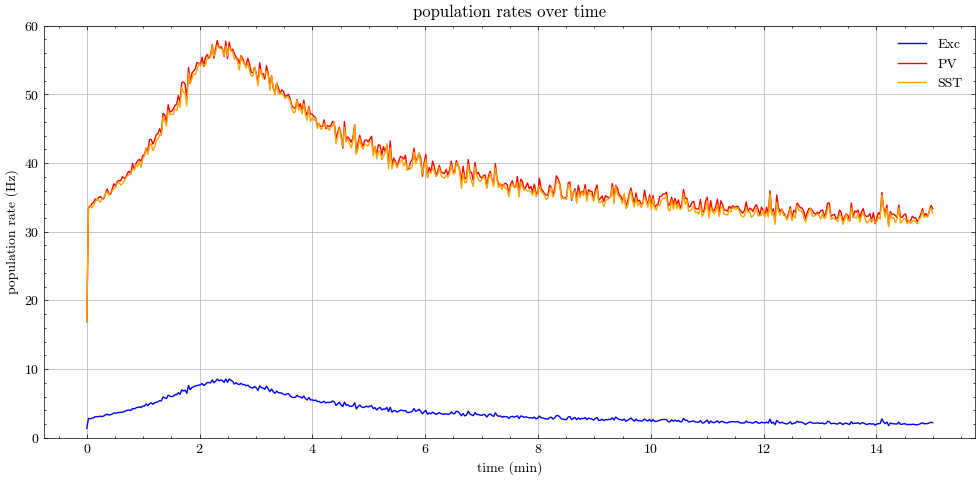

: 

In [ ]:
color_e='blue'
color_p='red'
color_s='orange'
nplot = 500
time_end = 15*60 # stop the plot at 15 min
pop_re_times_aligned = pop_re_times - time_warmup
idx_end = np.argmax(pop_re_times_aligned>time_end)
idxplot = np.linspace(start=1,stop=idx_end,num=nplot).round().astype(int) # subsample, as data points are too many
fig, ax = plt.subplots(1,1,figsize=(10, 5))
ax.plot(pop_re_times_aligned[idxplot]/60, pop_re_rates[idxplot], label='Exc',color=color_e)
ax.plot(pop_re_times_aligned[idxplot]/60, pop_rp_rates[idxplot], label='PV',color=color_p)
ax.plot(pop_re_times_aligned[idxplot]/60, pop_rs_rates[idxplot], label='SST',color=color_s)
ax.set_xlabel('time (min)')
ax.set_ylabel('population rate (Hz)')
ax.set_title('population rates over time')
ax.legend()
ax.set_ylim([0,60]) # to match the paper
ax.grid(True)
fig.tight_layout()
fig.savefig(f"../Figures/torus_two_interneurons_pop_rates_seed{tseed}.png", bbox_inches='tight', dpi=300)

In [13]:
def unband_and_center(mat, indexes=None):
    nrow, ncol = mat.shape
    if indexes is None:  # only works on square matrices
        indexes = np.arange(ncol)
    assert len(indexes) == nrow, "indexes must have same length as rows of mat"
    assert np.all((0 <= indexes) & (indexes <= ncol-1)), "indexes must be in the range 0:ncol-1"
    inddiff = np.diff(indexes)
    if np.any(inddiff > 1):
        raise ValueError("indexes are not contiguous")
    ret = np.empty((nrow, ncol), dtype=mat.dtype)
    ncenter = ncol // 2 - 1
    for i in range(nrow):
        for j in range(ncol):
            js = (j + indexes[i] ) % ncol
            ret[i, (j + ncenter) % ncol] = mat[i, js]
    return ret

def mean_and_norm(mat):
    ret = np.mean(mat, axis=0)
    ret /= np.max(ret)
    return ret

def mean_cols_nodiagonal(mat):
    nrows, ncols = mat.shape
    ret = np.empty(ncols, dtype=mat.dtype)
    for j in range(ncols):
        ret[j] = np.sum(np.delete(mat[:, j], j))
    ret /= (nrows - 1)
    return ret

def unband_mean_normalize(mat, indexes=None):
    if indexes is None:
        indexes = np.arange(1, mat.shape[1] + 1)
    mat_unband = unband_and_center(mat, indexes)
    means = mean_cols_nodiagonal(mat_unband)
    return means / np.max(means)

In [14]:
w_ee_full = np.zeros((NE,NE),dtype=float)
for (i,j,w) in zip(con_ee.i,con_ee.j,con_ee.w):
    w_ee_full[j,i] = w
w_es_full = np.zeros((NS,NE),dtype=float)
for (i,j,w) in zip(con_es.i,con_es.j,con_es.w):
    w_es_full[j,i] = w
w_se_full = np.zeros((NE,NS),dtype=float)
for (i,j,w) in zip(con_se.i,con_se.j,con_se.w):
    w_se_full[j,i] = w
w_ep_full = np.zeros((NP,NE),dtype=float)
for (i,j,w) in zip(con_ep.i,con_ep.j,con_ep.w):
    w_ep_full[j,i] = w
w_pe_full = np.zeros((NE,NP),dtype=float)
for (i,j,w) in zip(con_pe.i,con_pe.j,con_pe.w):
    w_pe_full[j,i] = w
    
w_ps_full = np.zeros((NS,NP),dtype=float)
for (i,j) in zip(con_ps.i,con_ps.j):
    w_ps_full[j,i] = w_ps
w_sp_full = np.zeros((NP,NS),dtype=float)
for (i,j) in zip(con_sp.i,con_sp.j):
    w_sp_full[j,i] = w_sp
w_pp_full = np.zeros((NP,NP),dtype=float)
for (i,j) in zip(con_pp.i,con_pp.j):
    w_pp_full[j,i] = w_pp
w_ss_full = np.zeros((NS,NS),dtype=float)
for (i,j) in zip(con_ss.i,con_ss.j):
    w_ss_full[j,i] = w_ss

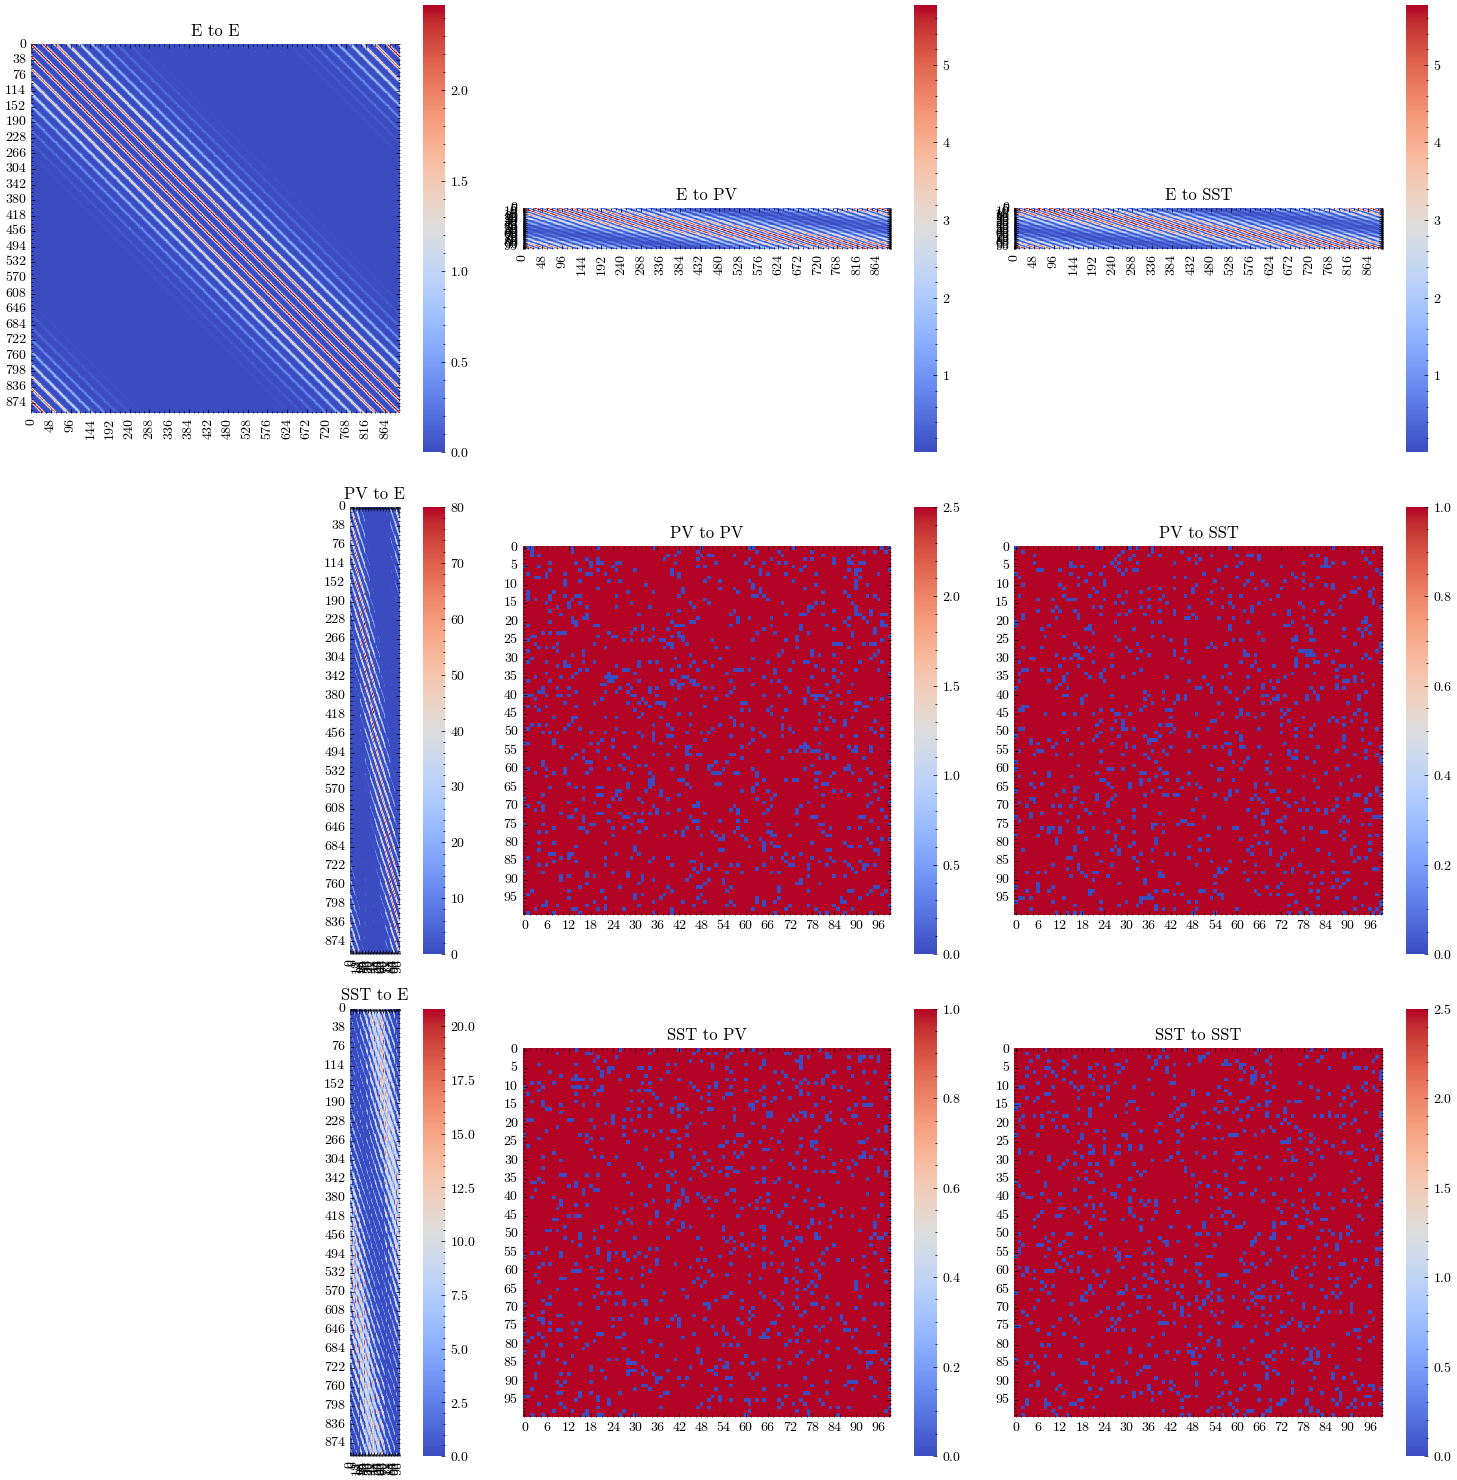

In [15]:
fig, ax = plt.subplots(3,3,figsize=(5*3,5*3))
sns.heatmap(w_ee_full, ax=ax[0,0], cmap='coolwarm', cbar=True, square=True)
ax[0,0].set_title('E to E')
sns.heatmap(w_ep_full, ax=ax[0,1], cmap='coolwarm', cbar=True, square=True)
ax[0,1].set_title('E to PV')
sns.heatmap(w_es_full, ax=ax[0,2], cmap='coolwarm', cbar=True, square=True)
ax[0,2].set_title('E to SST')

sns.heatmap(w_pe_full, ax=ax[1,0], cmap='coolwarm', cbar=True, square=True)
ax[1,0].set_title('PV to E')
sns.heatmap(w_pp_full, ax=ax[1,1], cmap='coolwarm', cbar=True, square=True)
ax[1,1].set_title('PV to PV')
sns.heatmap(w_ps_full, ax=ax[1,2], cmap='coolwarm', cbar=True, square=True)
ax[1,2].set_title('PV to SST')

sns.heatmap(w_se_full, ax=ax[2,0], cmap='coolwarm', cbar=True, square=True)
ax[2,0].set_title('SST to E')
sns.heatmap(w_sp_full, ax=ax[2,1], cmap='coolwarm', cbar=True, square=True)
ax[2,1].set_title('SST to PV')
sns.heatmap(w_ss_full, ax=ax[2,2], cmap='coolwarm', cbar=True, square=True)
ax[2,2].set_title('SST to SST')

fig.tight_layout()
fig.savefig(f"../Figures/torus_final_weights_seed{tseed}.png", bbox_inches='tight', dpi=300)

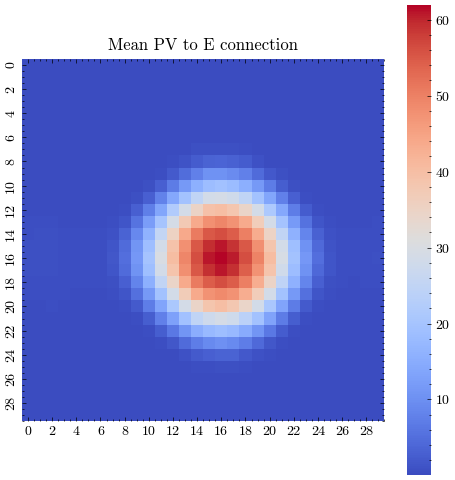

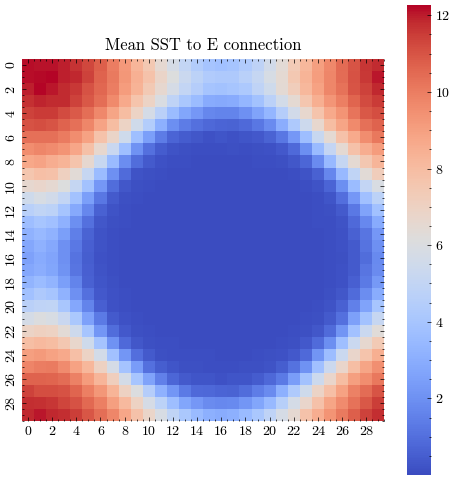

In [16]:
import math 

side_NE, side_NP, side_NS = int(math.sqrt(NE)), int(math.sqrt(NP)), int(math.sqrt(NS))
center_NP, center_NS = [side_NP // 2, side_NP // 2], [side_NS // 2, side_NS // 2]
grid_NE, grid_NP, grid_NS = 1 / side_NE, 1 / side_NP, 1 / side_NS

connection_pack = [[side_NP, center_NP, grid_NP, w_pe_full, "PV"],
                   [side_NS, center_NS, grid_NS, w_se_full, "SST"]]

for (side_Ninh, center_Ninh, grid_Ninh, w_inhe_full, inh_name) in connection_pack:
    one_inh_to_e_change_all = []
    # consider all inhibitiory neuron's connection to excitatory neurons
    # and move them to the center for comparison
    for neuron_inh in range(w_inhe_full.shape[1]):    
        one_inh_to_e = w_inhe_full[:, neuron_inh].reshape((side_NE, side_NE))
        inh_loc_index = [neuron_inh // side_Ninh, neuron_inh % side_Ninh]
        # move inh neuron to the center (in inh coordinates)
        move_index = [center_Ninh[0] - inh_loc_index[0], center_Ninh[1] - inh_loc_index[1]]
        # adjust the amount of shift in the excitatory grid
        move_p_dim = [round(move_index[0] * grid_Ninh / grid_NE), round(move_index[1] * grid_Ninh / grid_NE)]
        one_inh_to_e_change = np.roll(one_inh_to_e, move_p_dim, axis=(0, 1))
        one_inh_to_e_change_all.append(one_inh_to_e_change)

    one_inh_to_e_change_all = np.array(one_inh_to_e_change_all)
    mean_one_pv_to_e_change = np.mean(one_inh_to_e_change_all, axis=0)

    fig, ax = plt.subplots(1,1,figsize=(5,5))
    sns.heatmap(mean_one_pv_to_e_change, ax=ax, cmap='coolwarm', cbar=True, square=True)
    ax.set_title(f'Mean {inh_name} to E connection')
    fig.tight_layout()
    fig.savefig(f"../Figures/torus_mean_{inh_name}_to_e_rawconn_seed{tseed}.png", bbox_inches='tight', dpi=300)    


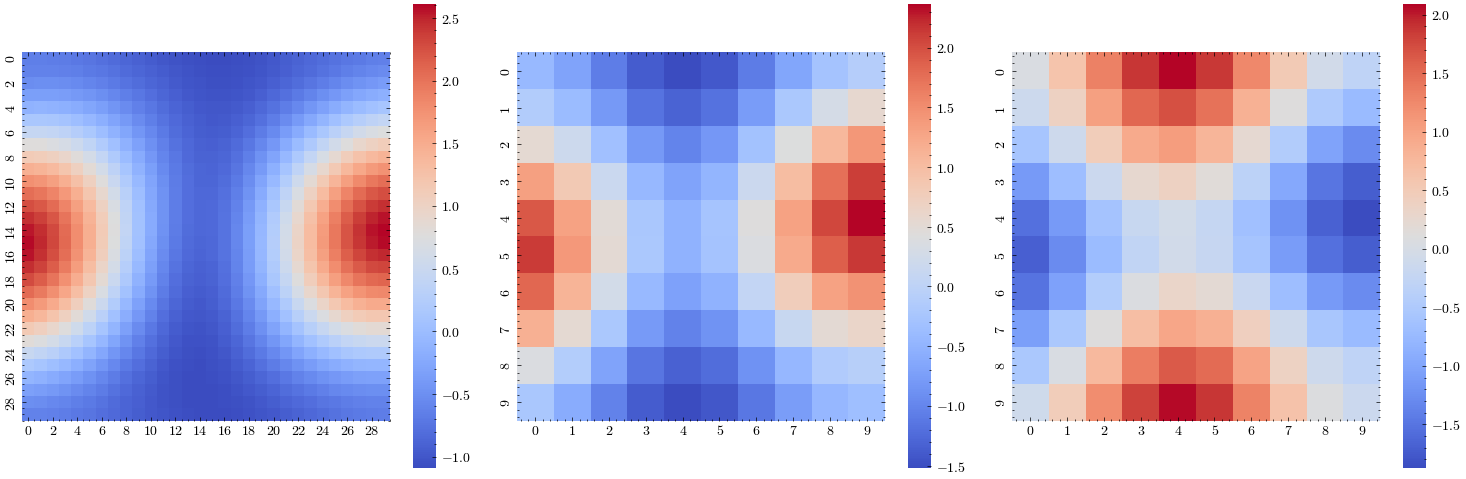

In [17]:
NTOT=NE+NP+NS
idx_e = np.arange(NE)
idx_p = NE+np.arange(NP)
idx_s = NE+NP+np.arange(NS)

w_full = np.zeros((NTOT,NTOT),dtype=float)
w_full[np.ix_(idx_e,idx_e)]=w_ee_full
w_full[np.ix_(idx_p,idx_e)]=w_ep_full
w_full[np.ix_(idx_e,idx_p)]=-w_pe_full
w_full[np.ix_(idx_p,idx_p)]=-w_pp_full

w_full[np.ix_(idx_s,idx_e)]=w_es_full
w_full[np.ix_(idx_e,idx_s)]=-w_se_full
w_full[np.ix_(idx_s,idx_s)]=-w_ss_full

w_full[np.ix_(idx_s,idx_p)]=-w_ps_full
w_full[np.ix_(idx_p,idx_s)]=-w_sp_full

# Just the sum of powers of the weight matrix
w_effective = (np.eye(NTOT) 
              + w_full 
               + w_full @ w_full 
               + w_full @ w_full @ w_full 
               + w_full @ w_full @ w_full @ w_full
               + w_full @ w_full @ w_full @ w_full  @ w_full  
               + w_full @ w_full @ w_full @ w_full  @ w_full @ w_full
)

dict_info = [[idx_e, "excitatory"], [idx_p, "PV"], [idx_s, "SST"]]

fig, ax = plt.subplots(1,3,figsize=(5*3,5))

for index, (idx, label) in enumerate(dict_info):
    w_effective_ee = w_effective[np.ix_(idx, idx)]
    profile_ee_effective=mean_and_norm(unband_and_center(w_effective_ee))
    profile_ee_effective_zscored = (profile_ee_effective - profile_ee_effective.mean()) / profile_ee_effective.std()
    reshape_ = int(math.sqrt(profile_ee_effective_zscored.shape[0]))

    sns.heatmap(profile_ee_effective_zscored.reshape((reshape_, reshape_)), ax=ax[index], cmap='coolwarm', \
        cbar=True, square=True)

fig.tight_layout()
fig.savefig(f"../Figures/torus_two_interneurons_effective_profile_seed{tseed}.png", bbox_inches='tight', dpi=300)

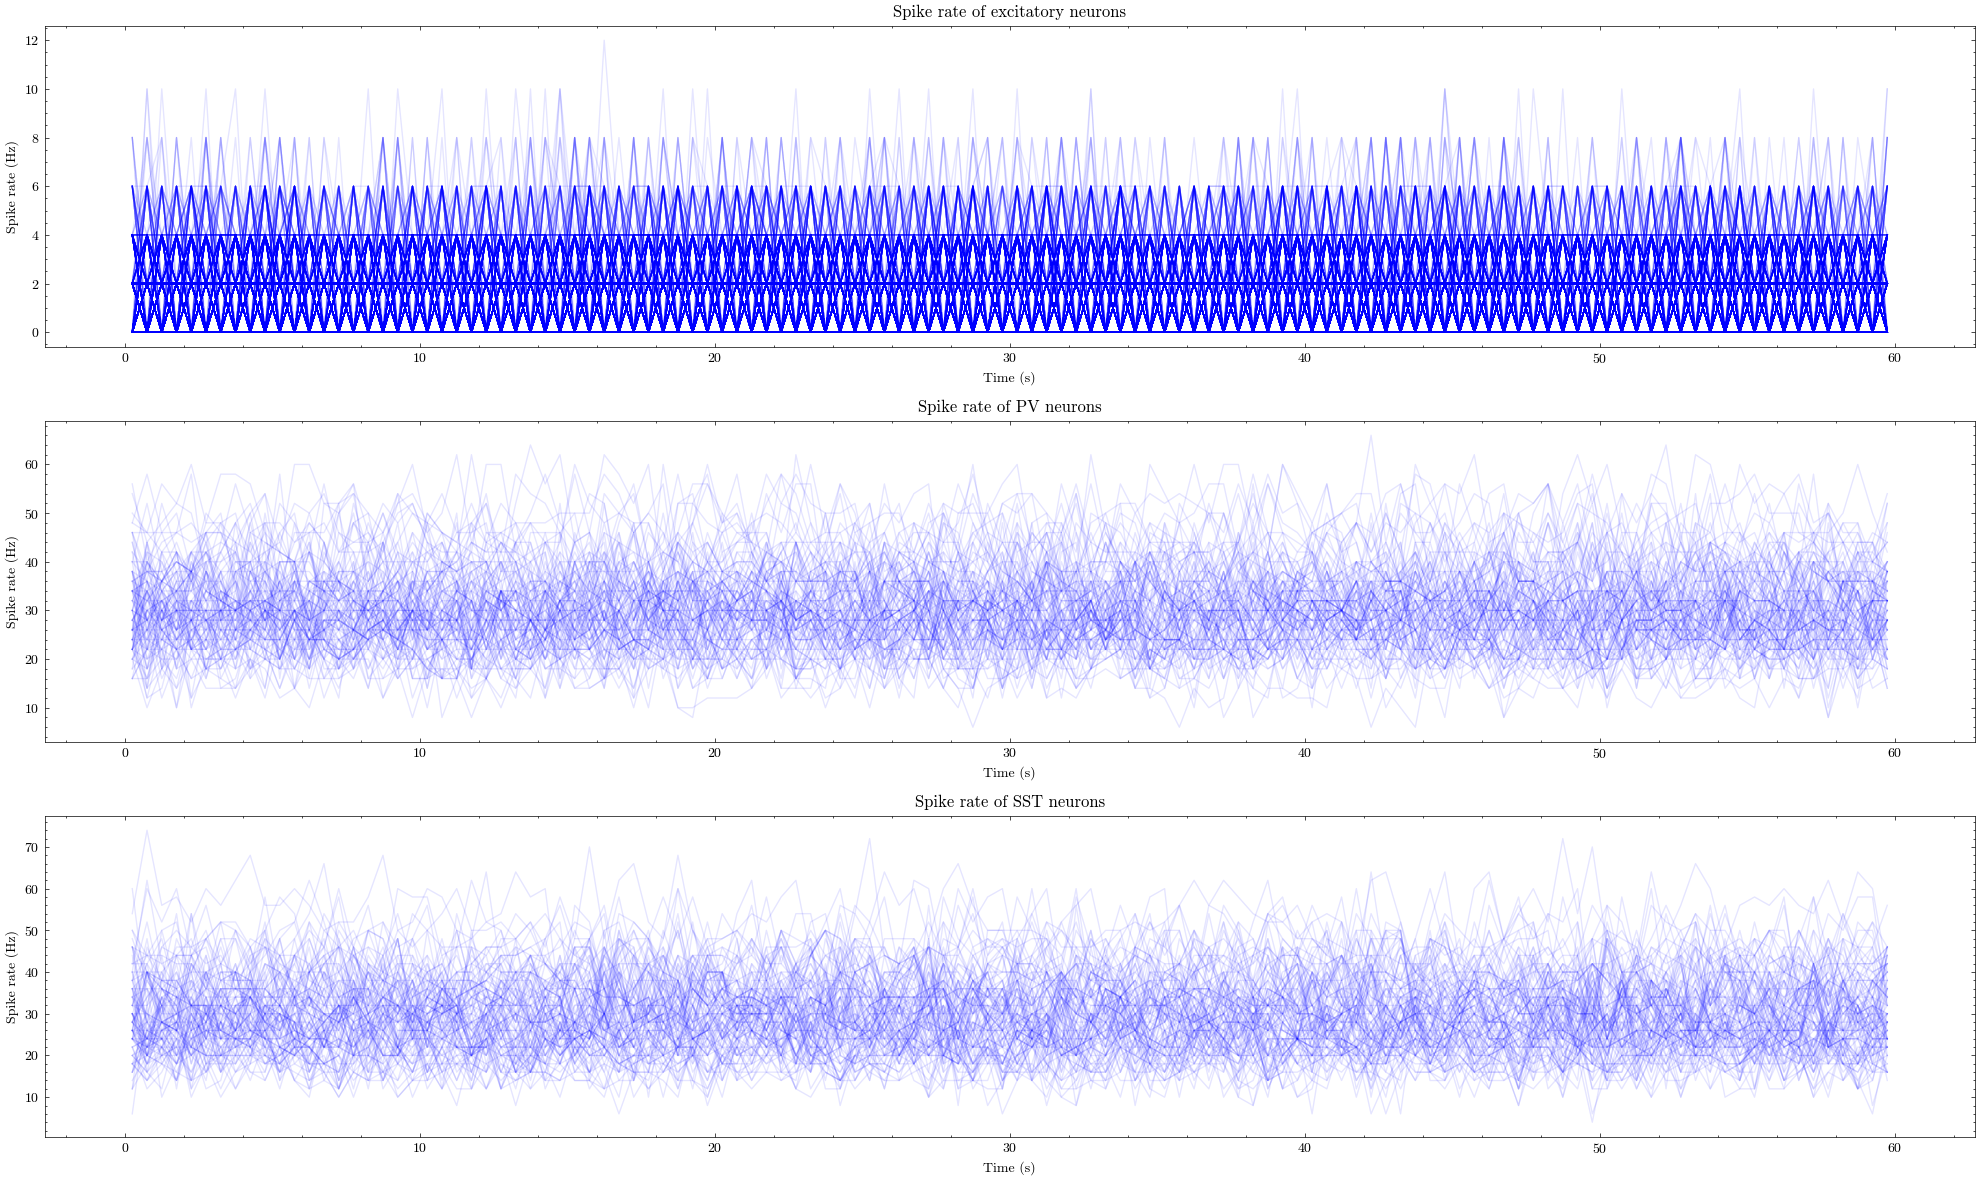

In [18]:
bin_width = 500.0 * 0.001 # in ms
t_start = 0
t_stop  = time_checkspikes                    
bins    = np.arange(t_start, t_stop + bin_width, bin_width)
t_axis = (bins[:-1] + bin_width/2)

fig, ax = plt.subplots(3,1,figsize=(20,4*3))
dict_info = [[NE, spk_e_mon, "excitatory"], [NP, spk_p_mon, "PV"], [NS, spk_s_mon, "SST"]]
for index, (NUM, spk_mon, spk_name) in enumerate(dict_info):
    for ne_index in range(NUM):
        spike_aligned = np.array(spk_mon.spike_trains()[ne_index]) - time_training - time_warmup
        counts, _ = np.histogram(spike_aligned, bins=bins)
        rate_hz   = counts / bin_width
        ax[index].plot(t_axis, rate_hz, color=color_e, alpha=0.1)
    ax[index].set_xlabel('Time (s)')
    ax[index].set_ylabel('Spike rate (Hz)')
    ax[index].set_title(f'Spike rate of {spk_name} neurons')
    
fig.tight_layout()
fig.savefig(f"../Figures/torus_two_interneurons_spikes_seed{tseed}.png", bbox_inches='tight', dpi=300)

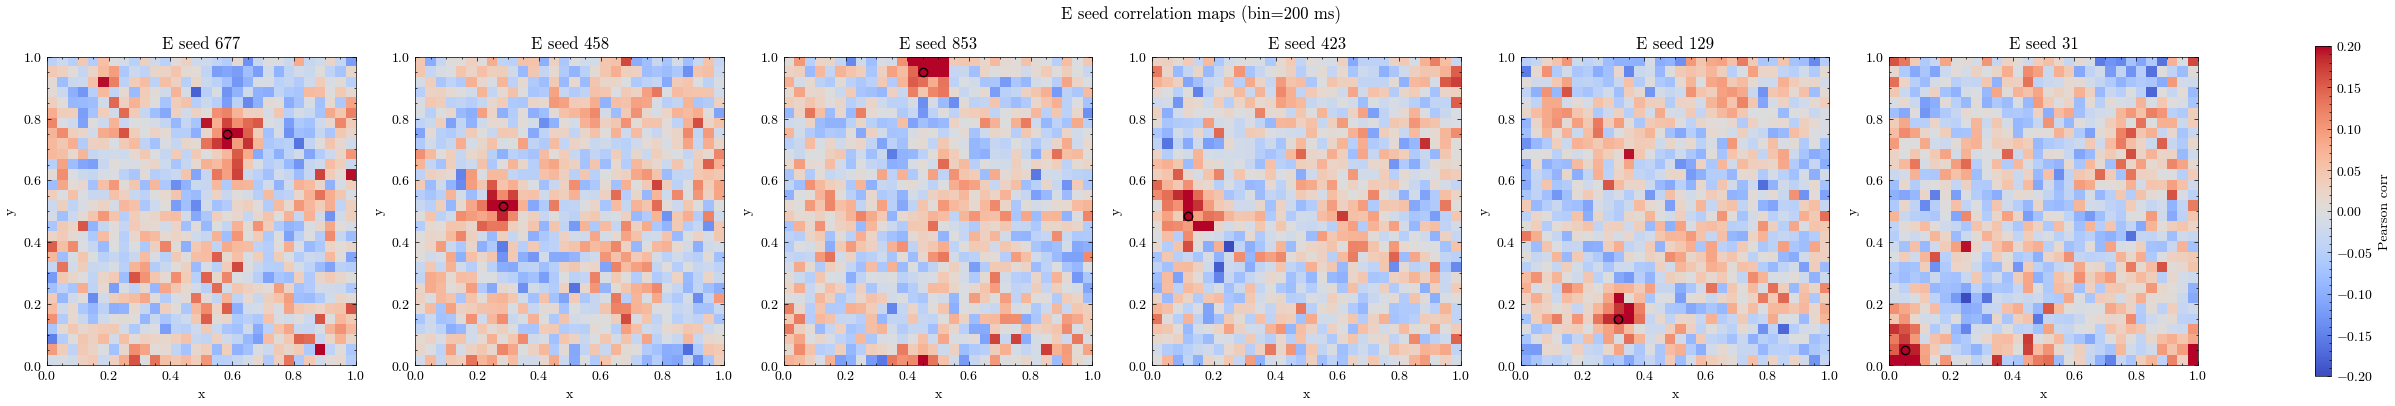

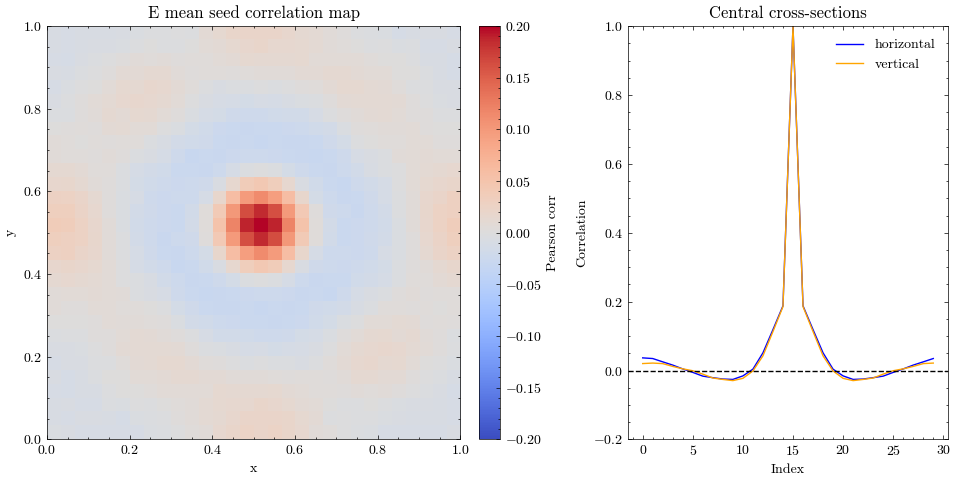

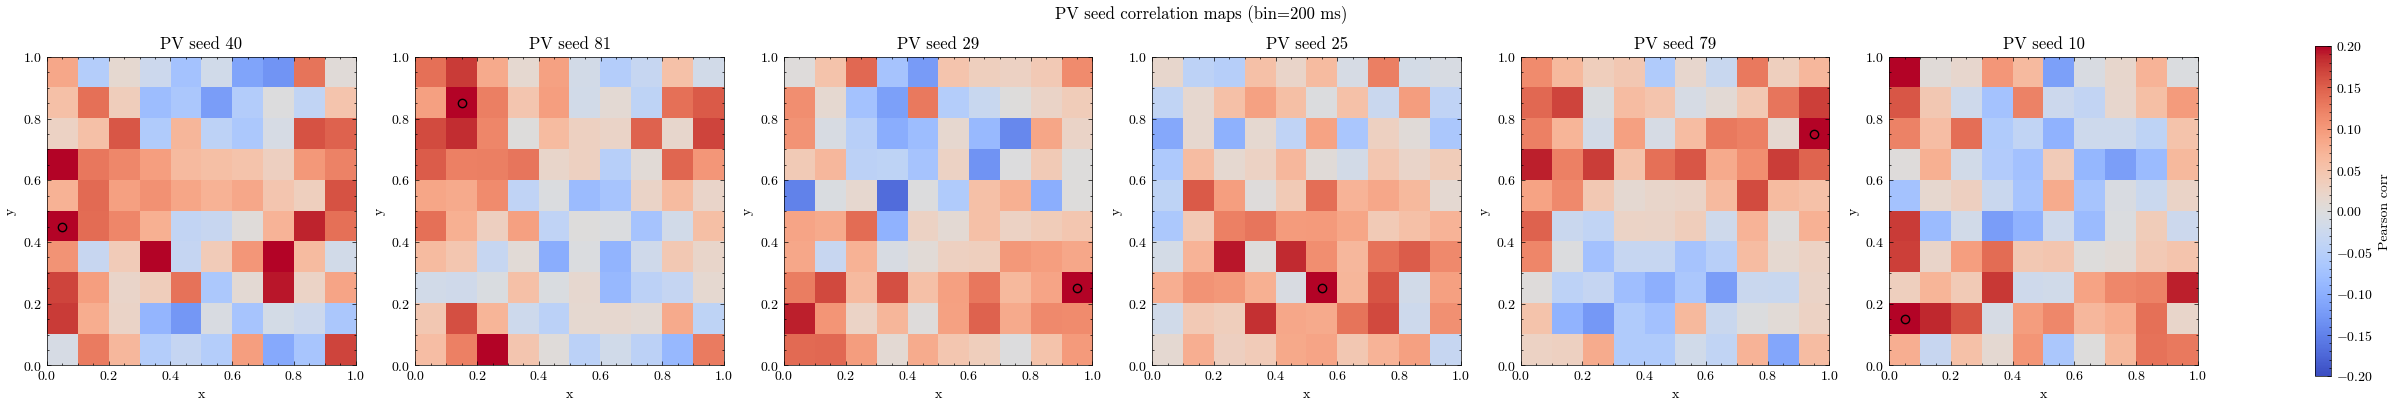

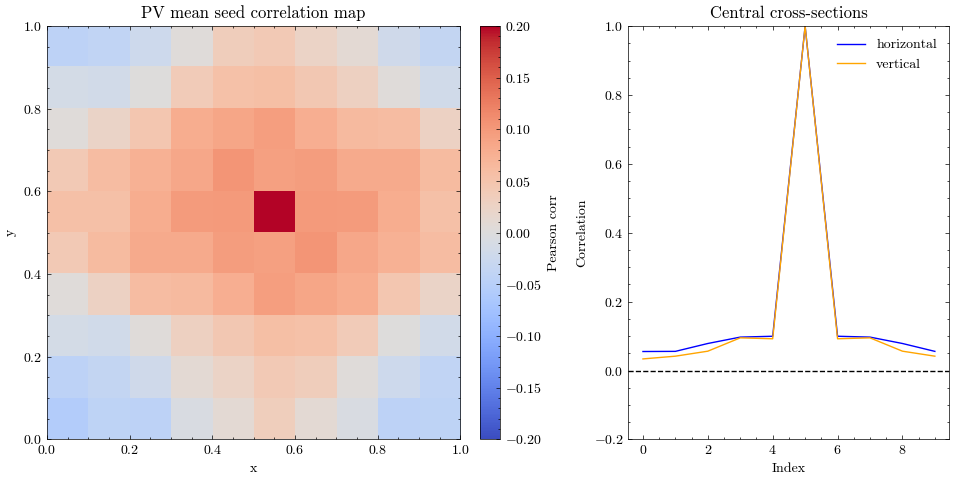

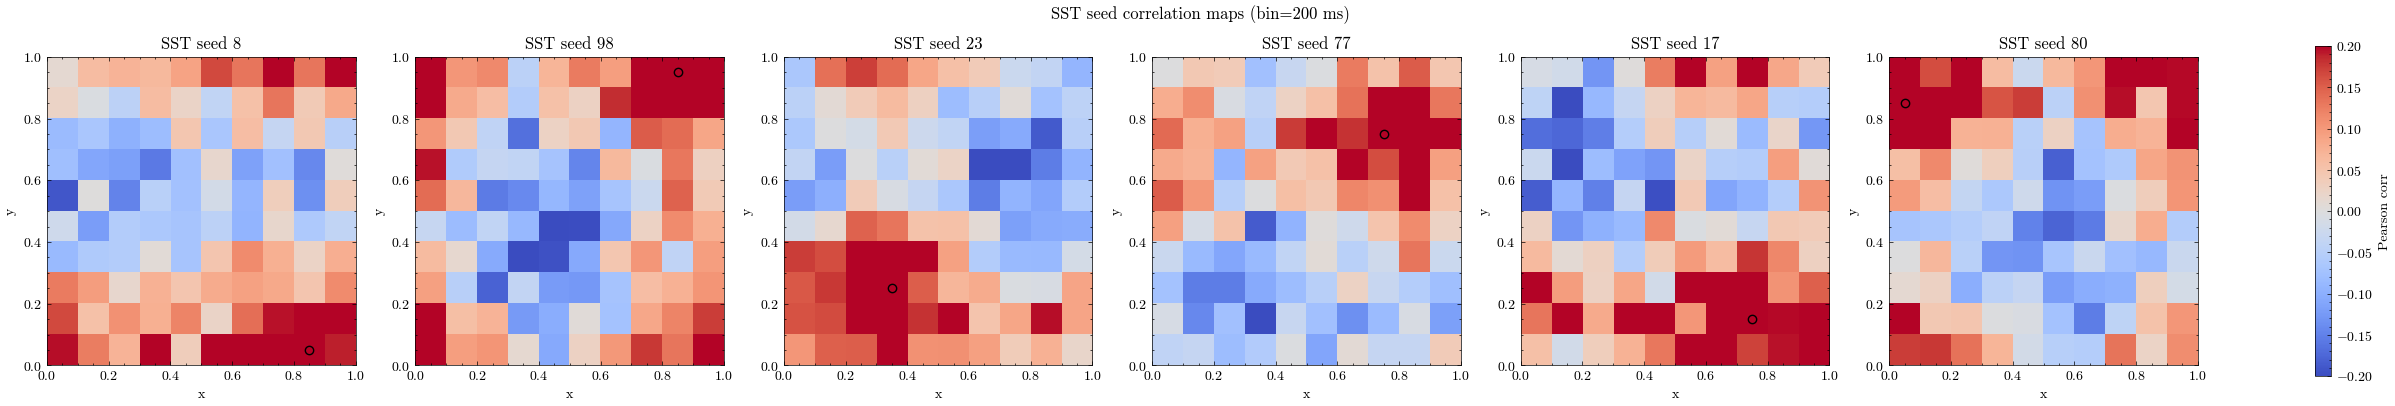

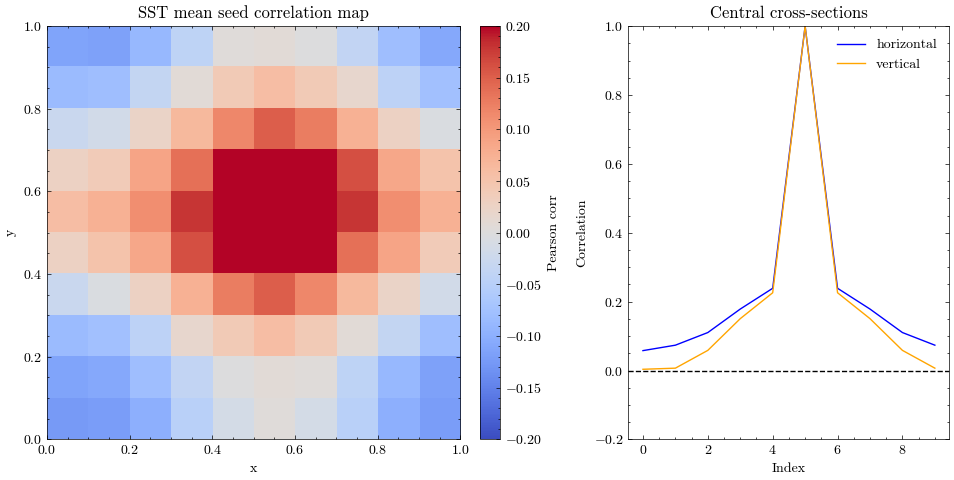

In [19]:
def grid_shape_like_assign(n, Lx=1.0, Ly=1.0):
    """
    """
    nx = int(np.round(np.sqrt(n * Lx / Ly)))
    nx = max(nx, 1)
    ny = int(np.ceil(n / nx))
    return nx, ny

def bin_to_assign_grid(x, y, val, n, Lx=1.0, Ly=1.0):
    """
    """
    nx, ny = grid_shape_like_assign(n, Lx, Ly)
    dx, dy = Lx / nx, Ly / ny

    ix = np.floor(x / dx).astype(int); ix = np.clip(ix, 0, nx-1)
    iy = np.floor(y / dy).astype(int); iy = np.clip(iy, 0, ny-1)

    Hsum = np.zeros((ny, nx), dtype=float)
    Hcnt = np.zeros((ny, nx), dtype=int)
    for ixx, iyy, v in zip(ix, iy, val):
        if np.isfinite(v):
            Hsum[iyy, ixx] += v
            Hcnt[iyy, ixx] += 1
    H = np.full((ny, nx), np.nan, dtype=float)
    m = Hcnt > 0
    H[m] = Hsum[m] / Hcnt[m]
    return H, nx, ny

def plot_seed_corr_maps_assign(pop_name, N, spk_mon, pos, Lx=1.0, Ly=1.0,
                               seeds_per_pop=6, bin_ms=200.0, rng_seed=0,
                               vlim=0.2):
    """
    """
    idx = np.array(spk_mon.i, dtype=np.int32)
    tt  = np.array(spk_mon.t/second, dtype=np.float64)
    if tt.size == 0:
        raise ValueError(f"No spikes recorded for {pop_name}.")
    t1 = float(tt[-1])
    t0 = t1 - float(time_checkspikes)
    dt = bin_ms / 1000.0
    edges = np.arange(t0, t1 + dt, dt)
    nb = len(edges) - 1

    m = (tt >= t0) & (tt < t1)
    idx = idx[m]; tt = tt[m]

    counts = np.zeros((nb, N), dtype=np.float32)
    if len(tt) > 0:
        bidx = np.floor((tt - t0) / dt).astype(np.int64)
        np.add.at(counts, (bidx, idx), 1.0)

    spike_totals = counts.sum(axis=0)
    keep = spike_totals >= 1
    counts = counts[:, keep]
    kept_idx = np.where(keep)[0]
    if counts.shape[1] < 2:
        raise ValueError(f"Not enough active neurons in {pop_name} after filtering.")

    mu = counts.mean(axis=0, keepdims=True)
    sd = counts.std(axis=0, ddof=1, keepdims=True)
    good = (sd[0] > 0)
    counts = counts[:, good]
    kept_idx = kept_idx[good]
    Z = (counts - mu[:, good]) / sd[:, good]
    T, M = Z.shape

    rng = np.random.default_rng(rng_seed)
    seed_cols = rng.choice(M, size=min(seeds_per_pop, M), replace=False)
    seed_cols_all = np.arange(M)

    fig, axs = plt.subplots(1, len(seed_cols), figsize=(4*len(seed_cols), 4), constrained_layout=True)
    if len(seed_cols) == 1:
        axs = [axs]

    H_all = []
    for _, sc in enumerate(seed_cols_all):
        cvec = (Z[:, sc].T @ Z) / (T - 1) 
        full_corr = np.full(N, np.nan, dtype=float)
        full_corr[kept_idx] = cvec

        H, _, _ = bin_to_assign_grid(pos[:,0], pos[:,1], full_corr, n=N, Lx=Lx, Ly=Ly)
        
        # calculate for all possible seeds, but only plot the selected ones
        if sc in seed_cols:
            k = np.where(seed_cols == sc)[0][0]
            ax = axs[k]
            im = ax.imshow(H, origin='lower', extent=[0, Lx, 0, Ly],
                        vmin=-vlim, vmax=+vlim, aspect='equal', cmap="coolwarm")

            seed_global = kept_idx[sc]
            ax.plot(pos[seed_global,0], pos[seed_global,1], marker='o', markersize=6, 
                    markeredgecolor='k', markerfacecolor='none')
            ax.set_title(f'{pop_name} seed {seed_global}')
            ax.set_xlabel('x')
            ax.set_ylabel('y')
            ax.grid(False)   
            
        N_root = int(math.sqrt(N))
        loc_index = [sc // N_root, sc % N_root]
        center_N = [int(N_root / 2), int(N_root / 2)]
        move_index = [center_N[0] - loc_index[0], center_N[1] - loc_index[1]]
        move_p_dim = [round(move_index[0]), round(move_index[1])]
        H_shift = np.roll(H, move_p_dim, axis=(0, 1))  
        H_all.append(H_shift)

    cbar = fig.colorbar(im, ax=axs, shrink=0.85)
    cbar.set_label('Pearson corr')
    fig.suptitle(f'{pop_name} seed correlation maps (bin={bin_ms:.0f} ms)', y=1.02)
    fig.savefig(f'../Figures/torus_two_interneurons_seed_corr_maps_{pop_name}_seed{tseed}.png',
                bbox_inches='tight', dpi=300)
    
    H_all = np.array(H_all)
    H_mean = np.mean(H_all, axis=0)   
    
    fig_mean, ax_mean = plt.subplots(
        1, 2, figsize=(10, 5),
        gridspec_kw={'width_ratios': [1.5, 1]} 
    )

    im_mean = ax_mean[0].imshow(
        H_mean, origin='lower', extent=[0, Lx, 0, Ly],
        vmin=-vlim, vmax=+vlim, aspect='equal', cmap="coolwarm"
    )
    ax_mean[0].set_title(f'{pop_name} mean seed correlation map')
    ax_mean[0].set_xlabel('x')
    ax_mean[0].set_ylabel('y')

    cbar = fig_mean.colorbar(im_mean, ax=ax_mean[0], fraction=0.046, pad=0.04)
    cbar.set_label('Pearson corr')

    hh = H_mean.shape[0] // 2
    ax_mean[1].plot(H_mean[hh, :], label='horizontal', color='blue')
    ax_mean[1].plot(H_mean[:, hh], label='vertical', color='orange')
    ax_mean[1].legend()
    ax_mean[1].set_ylim([-0.2, 1.0])
    ax_mean[1].axhline(0.0, ls='--', color='k', lw=1)
    ax_mean[1].set_title('Central cross-sections')
    ax_mean[1].set_xlabel('Index')
    ax_mean[1].set_ylabel('Correlation')

    fig_mean.tight_layout()
    fig_mean.savefig(
        f'../Figures/torus_seed_corr_maps_mean_{pop_name}_seed{tseed}.png',
        dpi=300
    )
    
bin_ms = 200.0
seeds_per_pop = 6

plot_seed_corr_maps_assign('E',   NE, spk_e_mon, pos_e, Lx=Lx, Ly=Ly,
                           seeds_per_pop=seeds_per_pop, bin_ms=bin_ms, rng_seed=1, vlim=0.2)
plot_seed_corr_maps_assign('PV',  NP, spk_p_mon, pos_p, Lx=Lx, Ly=Ly,
                           seeds_per_pop=seeds_per_pop, bin_ms=bin_ms, rng_seed=2, vlim=0.2)
plot_seed_corr_maps_assign('SST', NS, spk_s_mon, pos_s, Lx=Lx, Ly=Ly,
                           seeds_per_pop=seeds_per_pop, bin_ms=bin_ms, rng_seed=3, vlim=0.2)
